## Visualization

In [12]:
import os
import sys
import numpy as np
import pandas as pd
import pytorch_lightning as pl
sys.path.append("/kaggle/input/hms-helper-code")
from sklearn.model_selection import GroupKFold
from utils.config import Config
from utils.loss import KLDivLossWithLogits, CrossEntropyLossWithLogits
from eeg_dataset import EEGDataset, EEGSpecDataset, EEGWaveDataset, get_fold_dls
from exp import Experiment, KFoldModels
from tensorboard.backend.event_processing import event_accumulator
import numpy as np
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")


### Load the data

In [13]:
TARGETS = Config.TARGETS

### Load oof

In [15]:
oof_root = "/kaggle/input/hms-results/"
columns = ['pred_' + col for col in TARGETS]

oof_eeg = pd.read_csv(oof_root + "EEGModel_full/output/oof.csv")
oof_eeg["pred_target"] = oof_eeg[columns].values.argmax(axis=1)

oof_wave = pd.read_csv(oof_root + "EEGWaveNet_full/output/oof.csv")
oof_wave["pred_target"] = oof_wave[columns].values.argmax(axis=1)

oof_spec = pd.read_csv(oof_root + "EEGSpecNet_full/output/oof.csv")
oof_spec["pred_target"] = oof_spec[columns].values.argmax(axis=1)
oof_spec.head()

,eeg_id,spectogram_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target,fold,pred_seizure_vote,pred_lpd_vote,pred_gpd_vote,pred_lrda_vote,pred_grda_vote,pred_other_vote,pred_target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other,4,0.265079,0.025570,0.053241,0.035806,0.060268,0.560036,5
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD,1,0.026400,0.275903,0.008312,0.063844,0.014947,0.610594,5
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,4,0.006337,0.008682,0.007709,0.033522,0.232247,0.711503,5
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD,2,0.019391,0.693066,0.202549,0.005919,0.004818,0.074257,1
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,0,0.051985,0.043829,0.093049,0.094969,0.263551,0.452617,5


In [16]:
name_mapping = {"Seizure":0, "LPD":1, "GPD":2, "LRDA":3, "GRDA":4, "Other":5}
name_mapping_inv = {v:k for k,v in name_mapping.items()}

In [17]:
def cal_fold_rates(fold, oof):
    cur_fold_rates = []
    for ii, tt in enumerate(TARGETS):
        ttt = tt.split("_")[0].upper()
        # FIND TRAIN SAMPLES IN OOF (OUT OF FOLD) WITH TARGET >= 0.5
        base_condition = (
            (oof.fold == fold)
            & (oof[tt] >= 0.5)
            & (oof["target"] == name_mapping_inv[ii])
        )
        eeg_ids_new = oof.loc[base_condition, "eeg_id"].values
        eeg_ids = oof.loc[base_condition & (oof["pred_target"] == ii), "eeg_id"].values
        len_eeg_ids = len(eeg_ids)
        len_eeg_ids_new = len(eeg_ids_new)
        rate = len_eeg_ids / len_eeg_ids_new if len_eeg_ids_new > 0 else 0
        cur_fold_rates.append(rate)
        print(
            f"Found {len_eeg_ids}/{len_eeg_ids_new} samples ({rate:.3f}) in fold {fold} OOF for {tt} with true>0.5"
        )
    return cur_fold_rates

In [18]:
def get_fold_rates(oof):
    all_folds_rates = []
    for fold in range(0, 5):
        cur_fold_rates = cal_fold_rates(fold, oof)
        all_folds_rates.append(cur_fold_rates)

    fold_rates = pd.DataFrame(all_folds_rates, columns=TARGETS).T
    fold_rates["average"] = fold_rates.mean(axis=1)
    fold_rates["max"] = fold_rates.max(axis=1)
    return fold_rates

### Draw Radar Plot

In [19]:
fold_rates_eeg = get_fold_rates(oof_eeg)
fold_rates_wave = get_fold_rates(oof_wave)
fold_rates_spec = get_fold_rates(oof_spec)

fold_rates_eeg

,0,1,2,3,4,average,max
seizure_vote,0.662455,0.632696,0.678707,0.560878,0.636364,0.634220,0.678707
lpd_vote,0.334328,0.737679,0.417241,0.563506,0.738636,0.558278,0.738636
gpd_vote,0.632836,0.727536,0.805112,0.780488,0.744240,0.738042,0.805112
lrda_vote,0.015444,0.095588,0.125984,0.197452,0.129412,0.112776,0.197452
grda_vote,0.635088,0.510949,0.604811,0.587530,0.494033,0.566482,0.635088
other_vote,0.879310,0.884758,0.900574,0.882938,0.816817,0.872879,0.900574


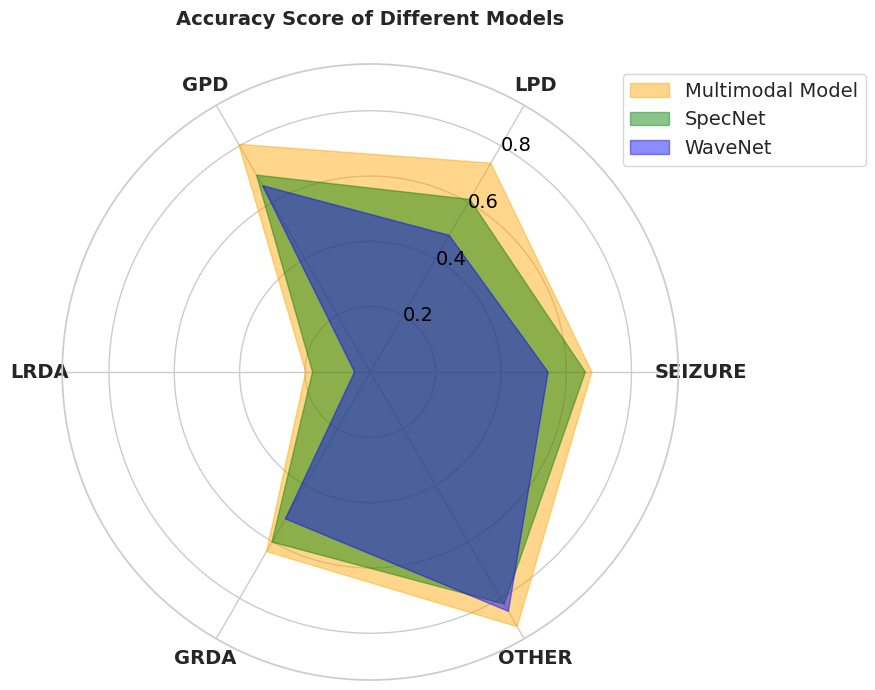

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

font_size = 14

categories = [tt.split("_")[0].upper() for tt in TARGETS]
all_values = [
    list(fold_rates_eeg["average"]),
    list(fold_rates_spec["average"]),
    list(fold_rates_wave["average"]),
]

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
colors = ["orange", "green", "blue"]
labels = ["Multimodal Model", "SpecNet", "WaveNet"]

for i, values in enumerate(all_values):
    ax.fill(angles, values + values[:1], color=colors[i], alpha=0.45, label=labels[i])


# Add radial ticks (from 0.2 to 0.8)
num_ticks = 4
max_radius = 0.8
radii = np.linspace(0.2, max_radius, num_ticks)

for r in radii:
    ax.text(
        1 / 3 * np.pi, r, f"{r:.1f}", color="black", fontsize=font_size, va="center"
    )  # Add text label at each radial position

ax.grid(True)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=font_size, fontweight="bold")
ax.legend(loc="upper right", bbox_to_anchor=(1.32, 1), fontsize=font_size)
sns.set(style="whitegrid")

plt.title(
    "Accuracy Score of Different Models", y=1.05, fontweight="bold", fontsize=font_size
)
plt.savefig("radar_plot_best.png", dpi=600, bbox_inches="tight")
plt.show()

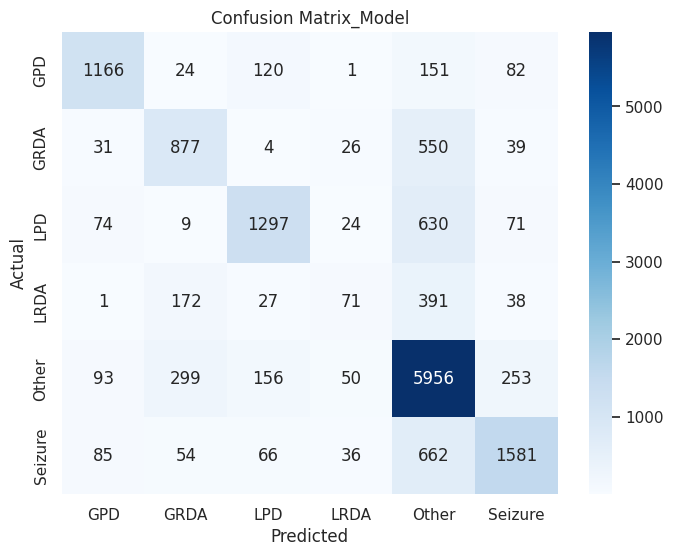

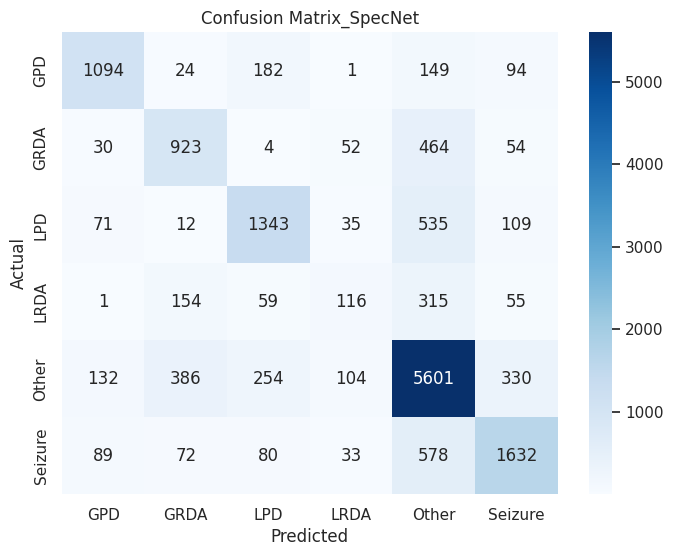

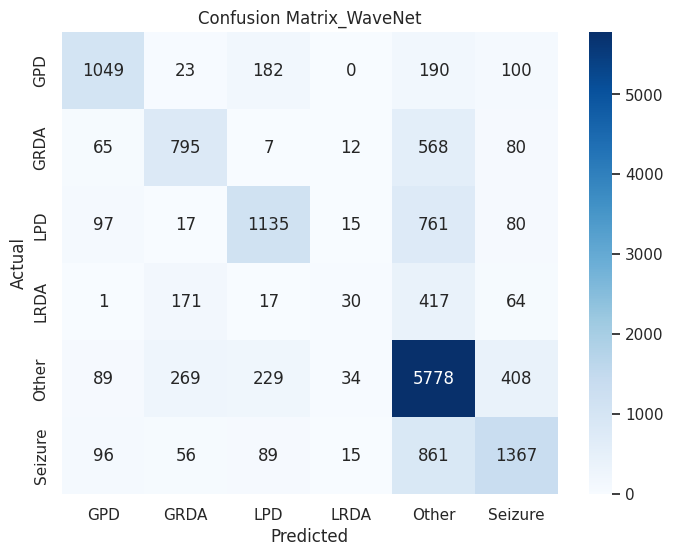

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

for path in ["Model", "SpecNet", "WaveNet"]:
    # Filter rows where the highest vote for each row is greater than 0.5
    df = pd.read_csv(f"/kaggle/input/hms-results/EEG{path}_full/output/oof.csv")
    df_filtered = df[
        df[
            [
                "seizure_vote",
                "lpd_vote",
                "gpd_vote",
                "lrda_vote",
                "grda_vote",
                "other_vote",
            ]
        ].max(axis=1)
        > 0.5
    ]
    pred_columns = [
        "pred_seizure_vote",
        "pred_lpd_vote",
        "pred_gpd_vote",
        "pred_lrda_vote",
        "pred_grda_vote",
        "pred_other_vote",
    ]
    df_filtered["predicted_class"] = (
        df_filtered[pred_columns].idxmax(axis=1).str.replace("pred_", "")
    )

    temp = []
    for t in df_filtered["predicted_class"]:
        if t == "other_vote":
            temp.append("Other")
        elif t == "seizure_vote":
            temp.append("Seizure")
        elif t == "lpd_vote":
            temp.append("LPD")
        elif t == "gpd_vote":
            temp.append("GPD")
        elif t == "lrda_vote":
            temp.append("LRDA")
        elif t == "grda_vote":
            temp.append("GRDA")
    df_filtered["predicted_class"] = temp

    conf_matrix = confusion_matrix(
        df_filtered["target"], df_filtered["predicted_class"]
    )

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=np.unique(df_filtered["target"]),
        yticklabels=np.unique(df_filtered["target"]),
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix_{path}")
    plt.show()

### Plot Overall accuracy and validation loss

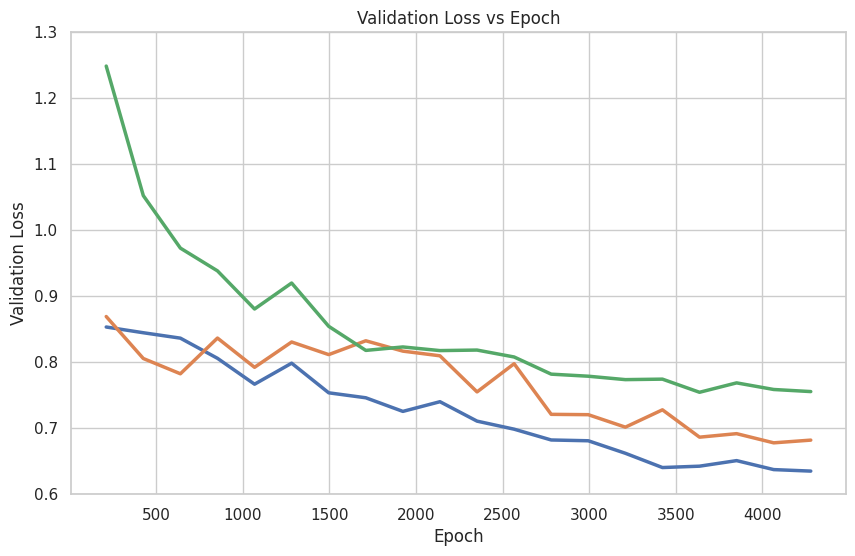

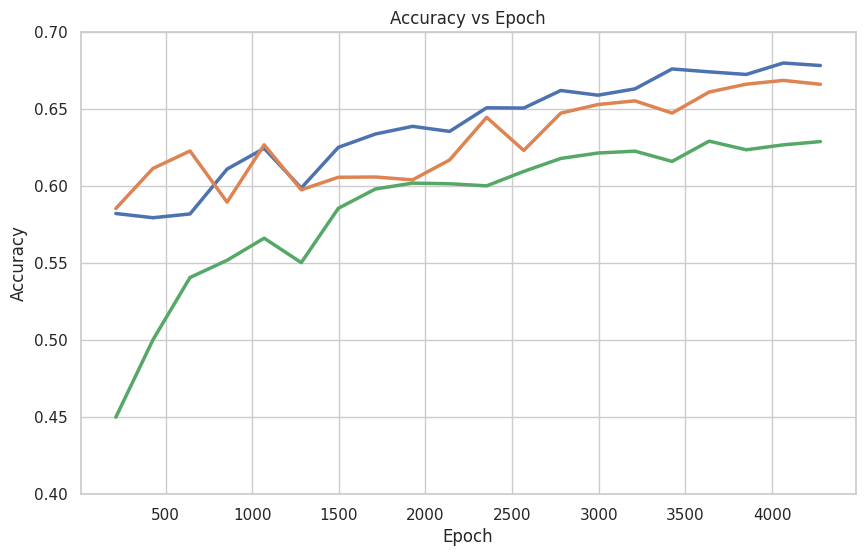

In [22]:
for metric in ['val_loss','val_acc']:
    dfs=[]
    for model in ['EEGModel','EEGSpecNet','EEGWaveNet']:
        version = 0
        directory = f'/kaggle/input/hms-results/{model}_full/lightning_logs/version_{version}/'
        files = os.listdir(directory)
        events_file = directory + [file for file in files if not file.endswith('.yaml')][0]
        event_acc = event_accumulator.EventAccumulator(events_file)
        event_acc.Reload()
        validation_summaries = event_acc.Scalars(f'{metric}_epoch')
        epochs = []
        val_losses = []
        for summary in validation_summaries:
            step = summary.step
            epoch = step  
            value = summary.value
            epochs.append(epoch)
            val_losses.append(value)
        df = pd.DataFrame({'Epoch': epochs, 'Value': val_losses})

        for version in range(1,5):
            directory = f'/kaggle/input/hms-results/{model}_full/lightning_logs/version_{version}/'
            files = os.listdir(directory)
            events_file = directory + [file for file in files if not file.endswith('.yaml')][0]
            event_acc = event_accumulator.EventAccumulator(events_file)
            event_acc.Reload()
            validation_summaries = event_acc.Scalars(f'{metric}_epoch')
            epochs = []
            val_losses = []
            for summary in validation_summaries:
                step = summary.step
                epoch = step 
                value = summary.value
                epochs.append(epoch)
                val_losses.append(value)
            temp = pd.DataFrame({'Epoch': epochs, 'Value': val_losses})
            df=df+temp
                
        dfs.append(df/5)

    plt.figure(figsize=(10, 6))
    df1 = dfs[0]
    df2 = dfs[1]
    df3 = dfs[2]
    
    plt.plot(df1['Epoch'], df1['Value'], label='Multimodal Model', linewidth=2.5)
    plt.plot(df2['Epoch'], df2['Value'], label='SpecNet', linewidth=2.5)
    plt.plot(df3['Epoch'], df3['Value'], label='WaveNet',linewidth=2.5)
    

    if metric == 'val_acc':
        plt.ylim(0.4,0.7)
        metric = 'Accuracy'
    elif metric == 'val_loss':
        metric = 'Validation Loss'
        plt.ylim(0.6,1.3)
        
    mpl.rcParams['font.size'] = 15 
    plt.xlabel('Epoch')
    plt.ylabel(f'{metric}')
    plt.title(f'{metric} vs Epoch')
    plt.grid(True)
    plt.gcf().patch.set_facecolor('none')
    plt.savefig(f'{metric}.png')
